## Building Univariate Time Series Models using Statistical Methods

Some popuar statistical modeling methods include

* exponential smooting
* non-seasonal autoregressive integrated moving average (ARIMA)
* seasonal ARIMA (SARIMA)
* Vector Autoregressive (VAR)


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse 
from sklearn.metrics import mean_absolute_percentage_error as mape 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from itertools import product 
from pathlib import Path 
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
# import data 
life_file = Path('../TimeSeriesAnalysisWithPythonCookbook/Data/life_expectancy_birth.csv')
milk_file = Path('../TimeSeriesAnalysisWithPythonCookbook/Data/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year', 
                   parse_dates=True, 
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)


<AxesSubplot:title={'center':'Monthly Milk Production'}, xlabel='month'>

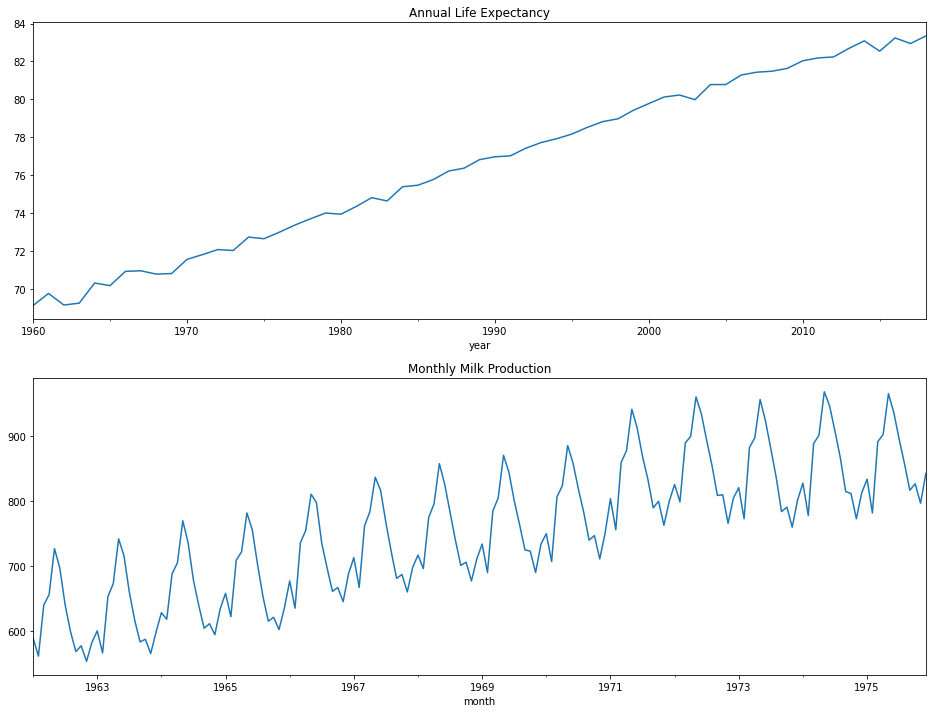

In [4]:
# inspect the data visually and obeserve if the time series contains any trend or seasonality

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title="Annual Life Expectancy", 
          legend=False, ax=ax[0])

milk.plot(title="Monthly Milk Production", 
          legend=False, ax=ax[1])

In [7]:
# Create a function to split data into test and train sets 

def split_data(data, test_split): 
    l = len(data)
    t_idx = round(l*(1-test_split))
    train,test = data[:t_idx], data[t_idx:]
    print(f'train: {len(train)}, test: {len(test)}')
    return train, test 

In [8]:
# Call the split_data function to split the DataFrames into test and train sets (15% test and 85% train)

test_split = 0.15

milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)


train: 143, test: 25
train: 50, test: 9


In [9]:
# Create a function for checking for stationarity

def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = "Stationary"
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return(s, results[0])


In [10]:
# Create function for hyperparameter tuning

def get_best_model(score, c="AIC"):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k 
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']


In [11]:
# Create the plot_forecast function which takes a model object that we have trained, a starting position and both the train and test datasets to create
# a plot that compares the forecast against actuals

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)

    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax) 
    forecast.plot(ax=ax, style='-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()
    

In [12]:
# Create a function that takes a list of parameters and returns a Cartesian product of these choices

def combinator(items):
    combo = [i for i in product(*items)]
    return combo 


## Plotting ACF and PACF


The ACF and PACF plots can help identify if the time series process is an AR, MA or ARMA process (if both are present) and the significant lag values (for p and q)

Both PACF and ACF plots are referred to as **correlograms** since the plots represent the correlation statistics

* ARMA assumes a stationary process
* ARIMA models does not since it handles the differencing

#### AR order vs. MA order 

* PACF plot estimates the AR order 
* ACF plot estimates the MA order

Statsmodels provides two functions: acf_plot and pacf_plot 

The correlation at lag zero is always one

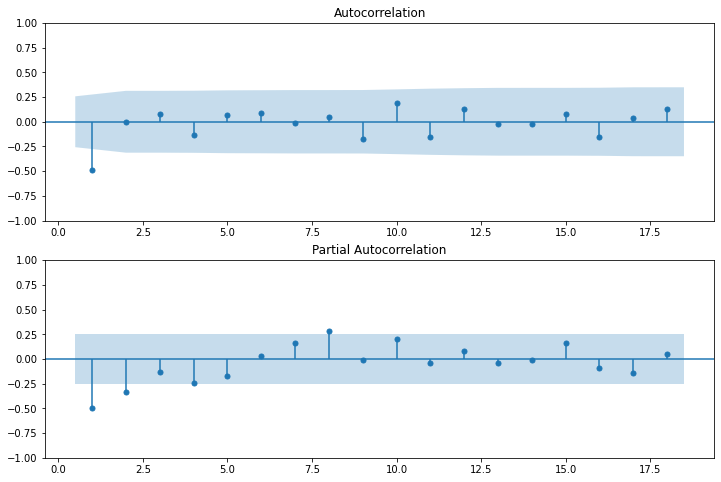

In [13]:
# differencing the time series 

life_diff = life.diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(12, 8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
plt.show()

In [14]:
milk_diff_12 = milk.diff(12).dropna()

In [15]:
# Use the check_stationarity function to perform an ADF test to check for stationarity

check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.16079880527711288 	 lags:12


('Non-Stationary', 0.16079880527711288)

In [16]:
# Perform a second differencing 
milk_diff_12_1 = milk.diff(12).diff(1).dropna()


In [17]:
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.865423431878859e-05 	 lags:11


('Stationary', 1.865423431878859e-05)

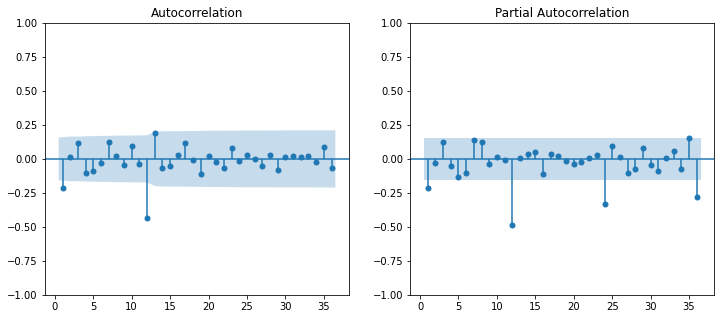

In [18]:
# Plot ACF and PACF for the stationary time series in milk_diff_12_1

fig,ax = plt.subplots(1,2)
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
plt.show()


ACF plot: 
* significant spike at lag 1, which represents the non-seasonal order for the MA process as q=1
* the spike at lag 12 represents the seasonal order for the MA process as Q=1. Notice that there is a cut-off right after lag 1, then a spike at lag 12, followed by a cut-off (no other significant lags afterward). These indicate a moving average model: an MA(1) for the non-seasonal component and an MA(1) for the seasonal component. 

PACF: 
* an exponential decay at lags 12, 24 and 36 indicates an Ma model. So the SARIMA model would be ARIMA (0, 1, 1)(0, 1, 1, 12)
 
The ACF and PACF plots can help us understand the strength of the linear relationship between past observations and their significance at different lags 

The ACF and PACF plot show significant autocorrelation or partial autocorrelation above the confindence interval. The shaded portion represents the confidence interval, which is controlled by the _alpha_ parameter in pacf_plot and acf_plot functions. The default value for alpha in statsmodels is 0.05. Being significant could be in either direction; strongly positive the close to 1 (above) or strongly negative the closer to -1 (below)

Example guide: 

Process                 ACF                                         PACF
AR(p)                 Gradual decay after lag p                   Cut-off after lag p

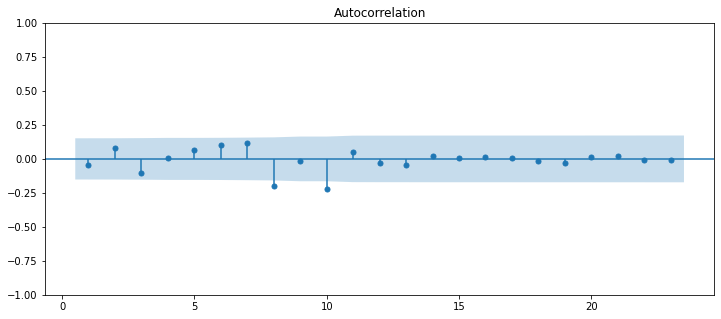

In [19]:
# ACF plot used to diagnose the model's residuals 
# build the seasonal ARIMA model as SARIMA(0,1,1)(0,1,1,12)
# then use the ACF to diagnose the residuals. If the model captured all the information that's 
# been embedded within the time series, we would expect the residuals to have no autocorrelation 

from statsmodels.tsa.statespace.sarimax import SARIMAX 
model = SARIMAX(milk, order=(0,1,1), 
                seasonal_order=(0,1,1,12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
plt.show()


Overall there are a couple of slightly significant lags, indicating the existence of some autocorrelation in the residuals. When the residuals show autocorrelation, this can mean that the model did not capture all the information, and there is potential for further improvement

We can further tune the model and experiment with other values for the seasonal and non-seasonal orders. 

## Forecasting univariate time series data with exponential smoothing 

In statsmodels there are three different implementations of exponential smooting, depending on the nature of the data we are working with

* **SimpleExpSmoothing** - Simple exponential smoothing is used when the time series process lacks seasonality and trend. This is also referred to as single exponential smoothing

* **Holt** - Holt's exponential smoothing is an enhancement of the simple exponential smoothing and is used when the time series process contains only trend (but no seasonality). It is referred to as double exponential smoothing

* **ExponentialSmoothing** - Holt-Winters' exponential smoothing is an enchancement of Holt's exponential smoothing and is used when the time series process has both seasonality and trend. It is referred to as triple exponential smoothing

In [20]:
# Import the ExponentialSmoothing class 
from statsmodels.tsa.api import ExponentialSmoothing


The ExponentialSmoothing takes several parameters

* smoothing_level: A float value for the smoothing factor for the level known as alpha 
* smoothing_trend: A float value for the smoothing factor for the trend  known as beta 
* smoothing_seasonal: A float value for the smoothing factor for the seasonal trend known as gamma
* trend: A single choic from (multiplicative or muk), (additive or add) or None 
* seasonal_periods: Takes an integer value representing the seasonality period, for ex. 12 (monthly) or 4 (quarterly)
* damped_trend: A Boolean value that is either True or False 
* use_boxcox: A Boolean value that is either True or False to determine if a Box-Cox transform should be applied

We can use the ExponentialSmoothing class to find the optimal values for alpha, beta and gamma



In [21]:
# Use the LifeExpectancy dataset and use the ExponentialSmoothing class

# For the life DataFrame we only have trend, so we only need to explore different values for the two parameters 
# that is, trend and damped

trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb 

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [24]:
# Loop through the combination list and train a different model at each iteration. 
# Capture the evaluation metrics in a dictionary to compare the results later. 

train = life_train.values.ravel()
y = life_test.values.ravel()

score = {}

for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                               trend=t, 
                               damped_trend = dp, 
                               seasonal = None)
    
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    score[i] = {'trend': t, 
                'damped': dp, 
                'AIC': model.aic, 
                'BIC': model.bic, 
                'AICc': model.aicc, 
                'RMSPE': rmspe(y, y_hat), 
                'RMSE': rmse(y, y_hat), 
                'MAPE': mape(y, y_hat), 
                'model': model}
    
    



To retrieve the best model using the get_best_model function, just pass the scores dictionary. For now, keep the default criteria set to c=AIC to be consistent

In [25]:
life_best_model = get_best_model(score, 'AIC')


Best model: 1 with lowest AIC score: -137.030601787416


In [26]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Sun, 09 Apr 2023"
Box-Cox:,False,Time:,01:28:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621954,alpha,True
smoothing_trend,0.1621954,beta,True


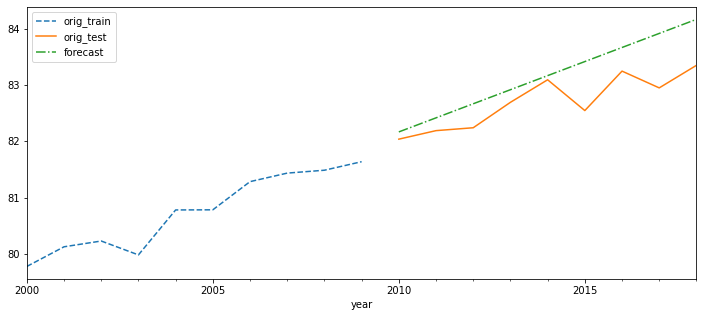

In [27]:
# We can forecast future values using the forecast method and then evaluate the results 
# against the test set
# the plot_forecast() function will produce the forecast and plot the results 

plot_forecast(life_best_model, '2000', life_train, life_test)

Replicate the process but using the milk dataframe. Keep in mind that the most significant difference here is the addition of the seasonal parameters. This means we will be adding two additional hyperparameters to evaluate for; seasonal and seasonal_periods

Build a cartesian product for the different options. For seasonal_periods we can explore three periods - 4, 6 and 12 months. This should give us a total of 24 models (2 x 2 x 2 x 3) = 24 

In [28]:
trend, damped = ['add', 'mul'], [True, False]
seasonal, periods = ['add', 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])


In [30]:
# Loop through the list of combinations to train multiple models and capture their scores :

train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}

for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                               trend=t,
                               damped_trend = dp, 
                               seasonal=s,
                               seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    milk_model_scores[i] = {'trend': t, 
                            'damped': dp,
                            'AIC': model.aic, 
                            'BIC': model.bic, 
                            'AICc': model.aicc, 
                            'RMSPE': rmspe(y, y_hat), 
                            'RMSE': rmse(y, y_hat), 
                            'MAPE': mape(y, y_hat), 
                            'model': model}

milk_model = get_best_model(milk_model_scores)
    

Best model: 8 with lowest AIC score: 593.7138861998106


In [31]:
# Print the model' summary 
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Sun, 09 Apr 2023"
Box-Cox:,False,Time:,01:45:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6858697,alpha,True
smoothing_trend,3.8173e-08,beta,True


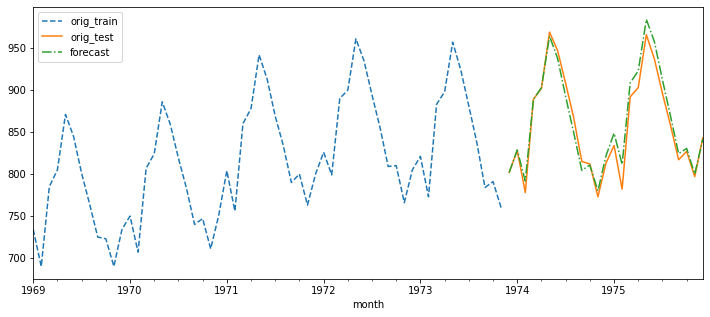

In [32]:
# Compare our forecast using the best model against the test data: 
plot_forecast(milk_model, '1969', milk_train, milk_test)


## Forecasting univariate time series data with non-essential ARIMA

In [34]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox 


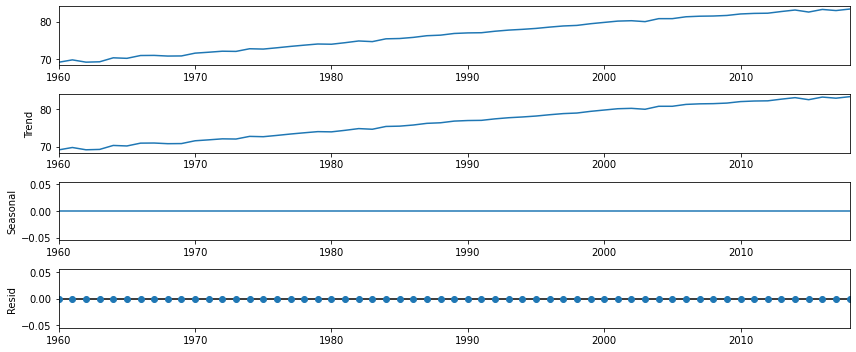

In [36]:
# Perform decomposition 
decomposed = seasonal_decompose(life)
decomposed.plot()
plt.show()

In [37]:
# First, detrend the data. Perform a first-order differencing and then test for stationarity 
life_df1 = life.diff().dropna()
check_stationarity(life_df1)


'Stationary	 p-value:1.556218967600307e-14 	 lags:1


('Stationary', 1.556218967600307e-14)

<AxesSubplot:xlabel='year'>

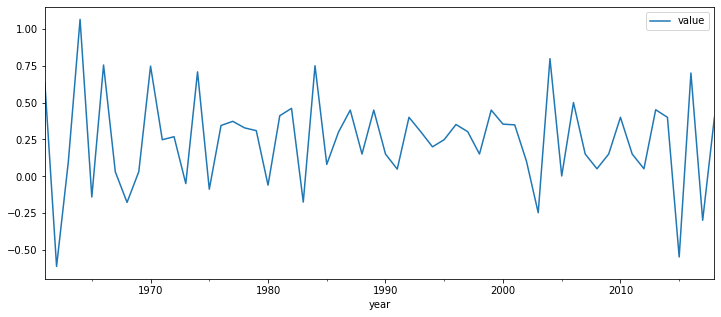

In [38]:
# Plot the differenced time series data using the plot method:

life_df1.plot()


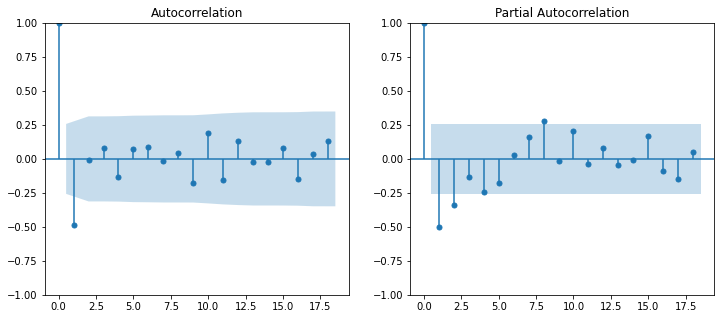

In [39]:
# Determine the p and q parameters for the ARIMA model
# The ACF and PACF plots will help us estimate the appropriate p and q values for the AR and MA models
fig,ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1])
plt.show()

The ACF plot shows a cut-off after lag1 - indicating an MA(1) model 

The PACF plot provides the significant lags for the AR(p) model. There is a gradual decay with oscillation after lag 1, indicating a MA model at lag 1 or MA(1)

This indicates a lack of an AR model, so the p order is zero AR(0)

An MA(1) process is also called a first-order process, indicating that the current value (at time t) is based on the value immediately preceding it (at time t-1)

Now, we can build the ARIMA(p,d,q) model using these values to get an ARIMA(0,1,1). 

In [40]:
# Train the ARIMA model on the training set, life_train and inspect the model's summary
# Don't use the differenced life_df1 version here, since ARIMA will apply differencing based
# on the value of the d parameter

model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Mon, 10 Apr 2023   AIC                             52.321
Time:                        13:50:08   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Notice that the AIC and BIC scores are provided, but they do not mean much in isolation - they are more meaningful when we're comparing multiple models

Since the ARIMA model is mainly an MA process with an integration factor, d, the summary results only provide the coefficient values for the MA(1) model. 

In [41]:
# Validate the residuals to determine if the ARIMA we built captured the signals in the T.S
# Assumption is that if the model captured all the information, the residuals from the model's 
# prediction are random (noise) and do not follow a pattern
# For example, we expect no autocorrelation in the residuals. 
# start by using the acorr_ljungbox test on the residuals

(acorr_ljungbox(results.resid, lags=25, return_df=True) < 0.05)['lb_pvalue'].sum()

0

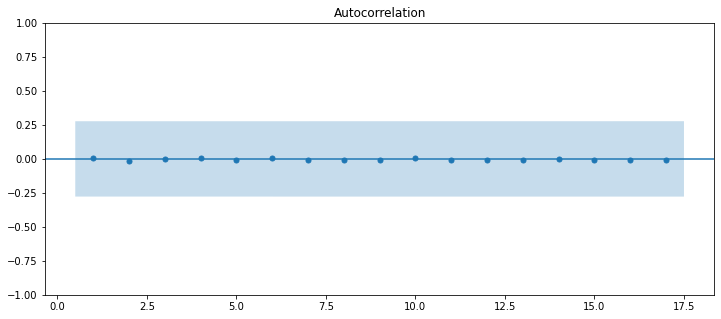

In [43]:
# Try the ACF plot 
plot_acf(results.resid, zero=False)
plt.show()

We expect to see no significant lags. All the vertical lines should be closer to zero or at zero for all lags

The above plot confirms no signs of autocorrelation 


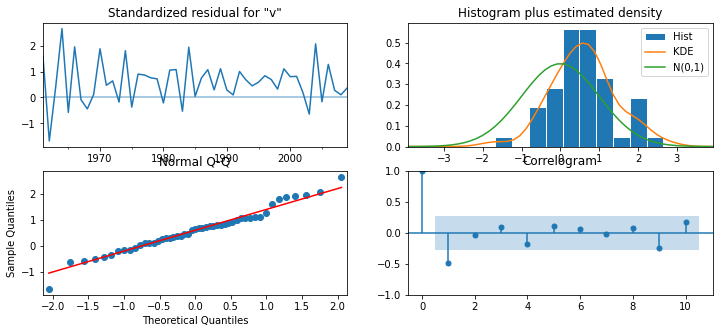

In [45]:
# We can also inspect the distribution of the residuals. We would expect normally distributed
# residuals with a mean of zero. We can use the QQ-plot and Kernel Density Estimation (KDE)
# plot to observe the distribution and assess normality
# We can accomplish this with the plot_diagnostics method

results.plot_diagnostics()
plt.show()

The plots show a slight deviation from a normal distribution. A perfect normally distributed dataset will have a perfect bell-curved KDE plot and all the points will be perfectly aligned on the line in the QQ plot

The results and diagnostics above indicate a decent model, though there might be room for improvements. Building an ARIMA model can be an iterative process that involves creating and testing different models. 



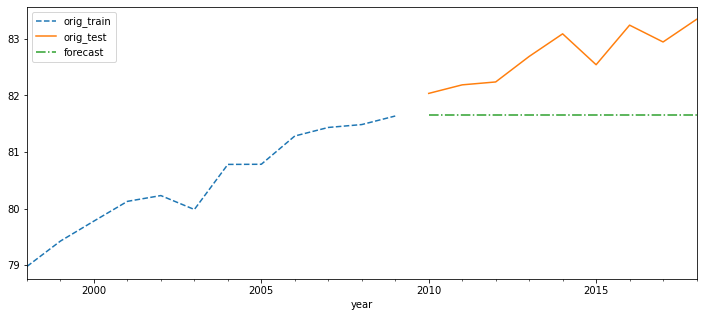

In [46]:
# Create a prediction and compare it with the test dataset
# use the plot_forecast() function

plot_forecast(results, '1998', life_train, life_test)


The model doesn't seem to produce good predictions. More testing is needed to get to a model that will produce a better forecast


It isn't easy to identify if the time series is an MA or AR process or determine the optimal order (lag) values for p or q. We can look at the following example of a grid search by trying different combinations for p, d and q to train other ARIMA models before picking a winning model. 

Here we will leverage the combinator() function and train multiple ARIMA models, and then use get_best_model() to find the best model. As a starter we try a combination of (0,1,2) for each of the hyperparameters. We will be testing 3x3x3 = 27 ARIMA models

In [47]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}

for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_train.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q), 
                'AIC': res.aic,
                'RMSPE': rmspe(y, y_hat), 
                'BIC': res.bic, 
                'AICc': res.aicc, 
                'RMSE': rmse(y, y_hat), 
                'MAPE': mape(y, y_hat), 
                'model': res}
best_m = get_best_model(score, 'AIC')


Best model: 8 with lowest AIC score: 7.698556606234497


In [48]:
# Running best_m.summary() we can see that the best model is an ARIMA(0,2,2)
 
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Mon, 10 Apr 2023   AIC                              7.699
Time:                        14:16:07   BIC                             13.312
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9448      4.232     -0.460      0.646     -10.239       6.350
ma.L2          0.9970      4.333      0.230      0.818      -7.495       9.489
sigma2         0.0500      0.218      0.229      0.819      -0.378       0.478
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# To view the results of all 27 models in a DataFrame, we can use the following command
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698557,1.654406,13.31216,8.244011,12.370882,0.164672,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.533201,1.638461,17.100482,10.442291,12.24011,0.162934,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.675161,1.653286,17.159965,10.605393,12.361971,0.164554,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,26,"(2, 2, 2)",10.666826,1.663706,20.022831,12.095398,12.444957,0.165654,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,23,"(2, 1, 2)",11.509378,1.636758,20.968479,12.904727,12.226425,0.162751,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.673176,1.714922,27.15798,20.603409,12.86579,0.171129,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.193405,1.697377,28.807008,23.73886,12.729597,0.16934,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.291259,1.687243,32.85854,26.20035,12.648817,0.168287,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.313602,1.698759,35.056004,31.580269,12.742592,0.1695,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.424965,1.674294,39.100426,33.958298,12.54746,0.166955,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


The Akaike Information Criteria (AIC) is a metric that aims to find a balance between a model's maximum likelihood and a model's simplicity. The AIC score penalizes as the number of parameters increases since the increase complexity

$AIC = 2k - 2 \ln(L^{*})$

Here, 2K is considered the penalty term 

The Bayesian Information Criteria (BIC) is very similar to AIC but has a higher penalty term on the model's complexity. In general, the BIC penalty term is more significant, so it can encourage models with fewer parameters than AIC does. 

$BIC = k \ln(n) - 2\ln(L^{*})$

Here, $L^{*}$ is the maximum likelihood, _k_ is the number of estimated parameters, and _n_ is the number of data points 



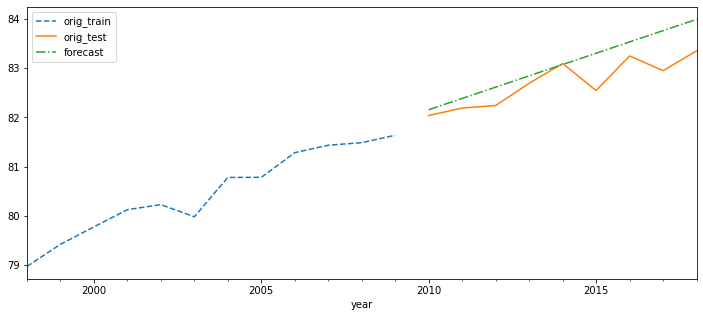

In [50]:
# Plot a forecast using the best model
plot_forecast(best_m, '1998', life_train, life_test)

## Forecasting univariate time series data with seasonal ARIMA 

Like an ARIMA(p,d,q) a SARIMA model also requires (p,d,q) to represent non-seasonal orders. Additionally, a SARIMA model requires the orders for the seasonal component, which is denoted as (P, D, Q, s). Combining both components, the model can be written as a SARIMA(p, d, q)(P, D, Q, s). The lower-case letters represent the seasonal orders. The new parameter s, is the number of steps per cycle, for example s=12 for monthly data or s=4 for quarterly data 

In statsmodels we will use the SARIMAX class to build a SARIMA model 

In [51]:
# Start by importing the necessary libraries 
from statsmodels.tsa.statespace.sarimax import SARIMAX 


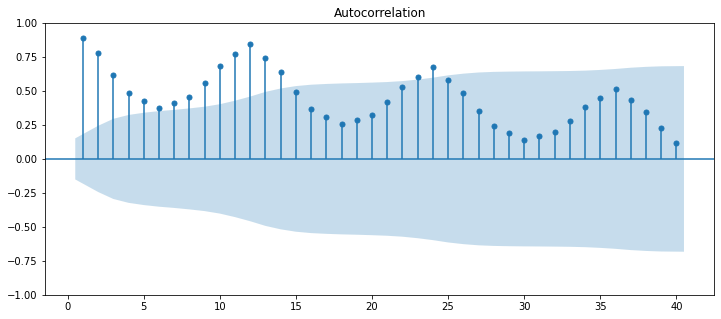

In [52]:
# ACF plot, to confirm that the number of periods in a season is 12 
plot_acf(milk, lags=40, zero=False)
plt.show()


Notice that there is a repeating pattern every 12 months (lags). If the pattern is not east to spot, we can try the ACF plot after we difference the data. For example, detrend (first-order differencing) the data first, then plot the ACF plot: 


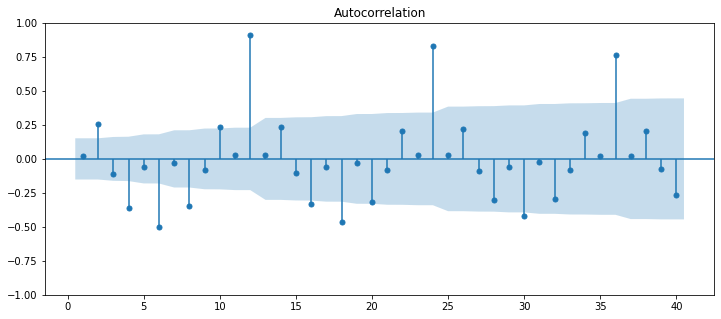

In [53]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False)
plt.show()

This should produce an ACF plot on the differenced data  that makes the seasonal spikes more apparent

We can also extract the seasonal component and use that for the ACF plot

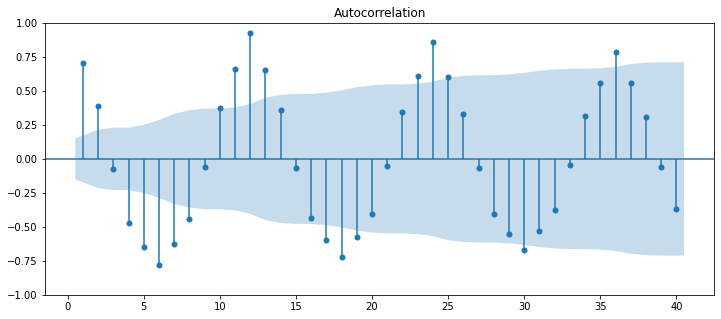

In [54]:
#extract seasonal component and use for ACF plot 
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
milk_s = decomposed.seasonal
plot_acf(milk_s, zero=False, lags=40)
plt.show()

Generally, we can assume a 12-month cycle when working with monthly data. For example, for the non-seasonal ARIMA portion, start with d=1 for detrending, and for the seasonal ARIMA portion, start with D=1 as well, given s=12



Suppose we are not sure about the values for d (non-seasonal differencing) and D (seasonal differencing). In that case, we can use the check_stationarit function after differencing to determine if seasonal differencing was enough or not. In most cases, if the time series has both trend and seasonality, we may need to difference twice. First, we perform seasonal differencing, followed by a first-order differencing for detrending

'Non-Stationary	 p-value:0.6274267086030293 	 lags:13
'Non-Stationary	 p-value:0.16079880527711288 	 lags:12
'Stationary	 p-value:1.865423431878859e-05 	 lags:11


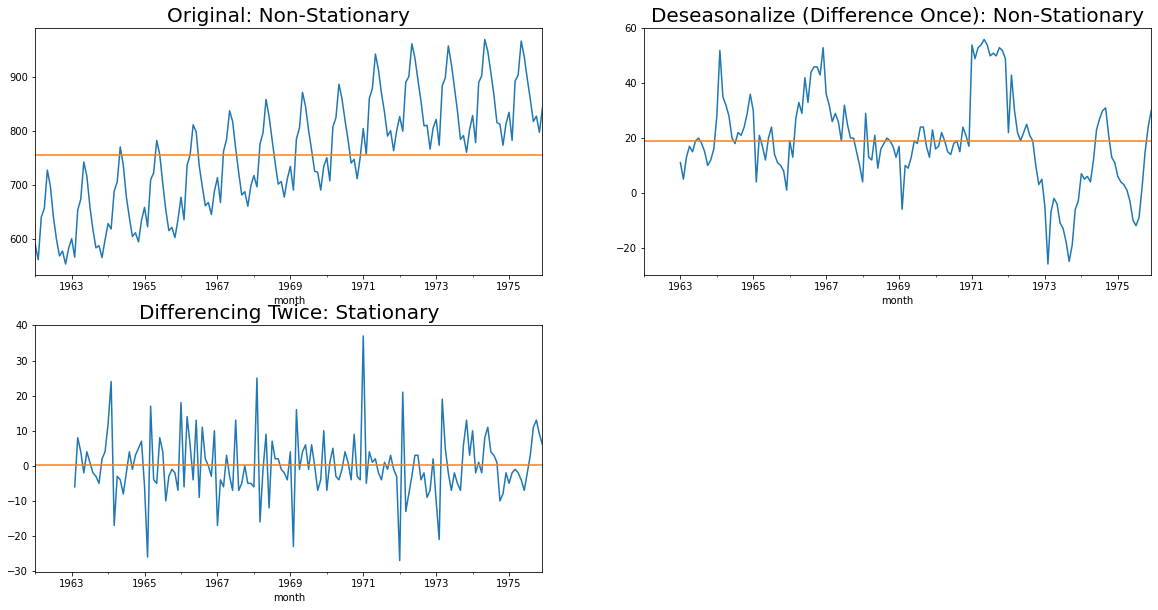

In [57]:
# Start with seasonal differencing by using diff(12) and test if that is enough to make the time
# series stationary. If not, then we will need to follow it with a first-order differencing

milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize (Difference Once)', 'Differencing Twice']
fig, ax = plt.subplots(2,2, figsize=(20,10))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax=ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
plt.show()

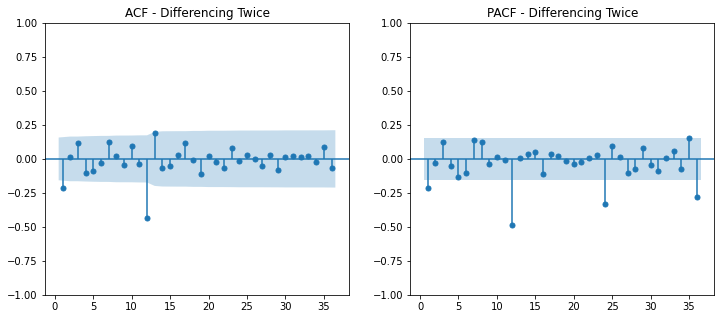

In [60]:
# Now we need to estimate the MA and AR orders for the non-seasonal (p, q) and seasonal 
# components (P, Q). To do this, we must use the ACF and PACF plots on the stationary data 
# which can be found in the milk_dif_12_1 DF 

fig,ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

ACF plot:
 - there is a significant spike at lag 1, which represents the non-seasonal order for the MA process. The spike at lag 12 represents the seasonal order for the MA process. Notice that there is a cut-off. These are indications of a moving average model - more specifically, an order of q=1 and Q=1

PACF plot: 
 - an exponential decay at lags 12,24 and 36 indicates an MA model. Here, the seasonal ARIMA would be ARIMA(0,1,1)(0,1,1,12) 



Build the SARIMA model based on the initial information that was extracted for the AR and MA orders. The following code will fit a SARIAMA(0,1,1)(0,1,1,12) model on the training dataset. 

In [61]:
sarima_model = SARIMAX(milk_train, order=(0,1,1), seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

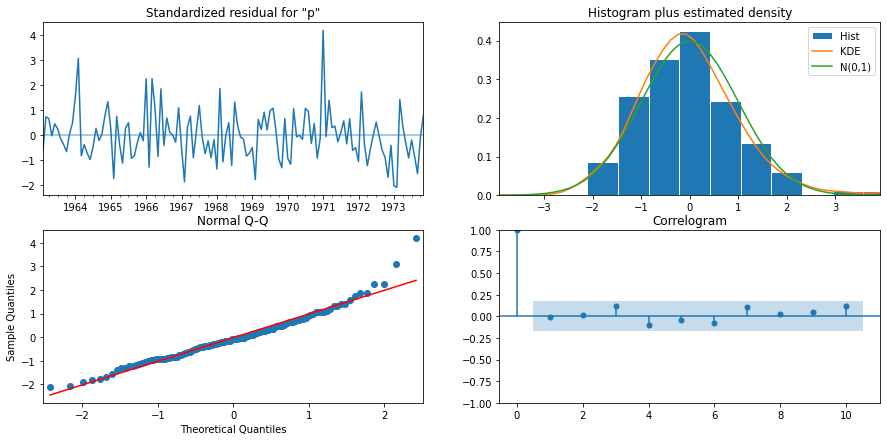

In [62]:
# Use the plot_diagnostics method 
model.plot_diagnostics(figsize=(15,7))
plt.show()

In [63]:
# Obtain the summary using the summary method 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Mon, 10 Apr 2023   AIC                            903.335
Time:                                    17:03:32   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

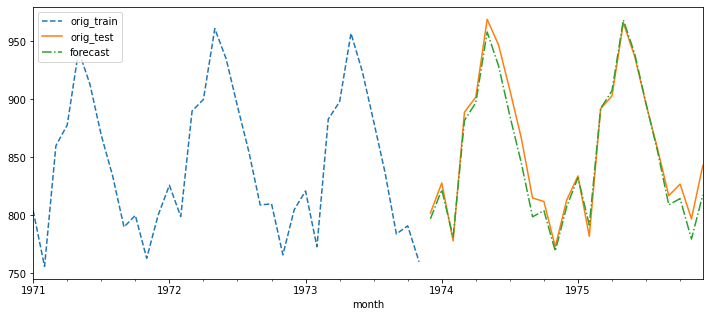

In [64]:
# Use the plot_forecast function to plot the forecast from the SARIMA model and compare it 
# with the test set

plot_forecast(model, '1971', milk_train, milk_test)

Overall the SARIMA model did a great job of capturing the seasonal and trend effects. We can always iterate and test different values for (p,q) and (P,Q) by evaluating the results using other metrics such as RMSE, MAPE or AIC etc. 


In [65]:
# Use grid search to test different model configurations 
P_ns, D_ns, Q_ns = [list(range(3))]*3 
P_s, D_s, Q_s = [list(range(2))]*3 

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {} 
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p}, {d}, {q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q), 
                seasonal_order=(P, D, Q, 12), 
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q), 
                'seasonal order': (P,D,Q), 
                'AIC': res.aic, 
                'AICc': res.aicc, 
                'BIC': res.bic, 
                'RMSPE': rmspe(y, y_hat), 
                'RMSE': rmse(y, y_hat), 
                'MAPE': mape(y, y_hat), 
                'model': res}

Running model #0 using SARIMA(0, 0, 0)(0,0,0,12)
Running model #15 using SARIMA(0, 0, 1)(1,1,1,12)
Running model #30 using SARIMA(0, 1, 0)(1,1,0,12)
Running model #45 using SARIMA(0, 1, 2)(1,0,1,12)
Running model #60 using SARIMA(0, 2, 1)(1,0,0,12)
Running model #75 using SARIMA(1, 0, 0)(0,1,1,12)
Running model #90 using SARIMA(1, 0, 2)(0,1,0,12)
Running model #105 using SARIMA(1, 1, 1)(0,0,1,12)
Running model #120 using SARIMA(1, 2, 0)(0,0,0,12)
Running model #135 using SARIMA(1, 2, 1)(1,1,1,12)
Running model #150 using SARIMA(2, 0, 0)(1,1,0,12)
Running model #165 using SARIMA(2, 0, 2)(1,0,1,12)
Running model #180 using SARIMA(2, 1, 1)(1,0,0,12)
Running model #195 using SARIMA(2, 2, 0)(0,1,1,12)
Running model #210 using SARIMA(2, 2, 2)(0,1,0,12)


In [66]:
# Evaluate the winning model 
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.4217652357268


In [67]:
# Let's inspect model number 211
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 795.4217652357268,
 'AICc': 796.2068119646988,
 'BIC': 811.8389559260937,
 'RMSPE': 0.17818983074437594,
 'RMSE': 15.135855827421533,
 'MAPE': 0.014454255417750117,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1690954e8c0>}

The best model was a SARIMA(2,2,2)(0,1,1,12). This is different from the earlier model we estimated as SARIMA(0,1,1)(1,1,12). 

We can now forecast and plot the model using the plot_forecast function

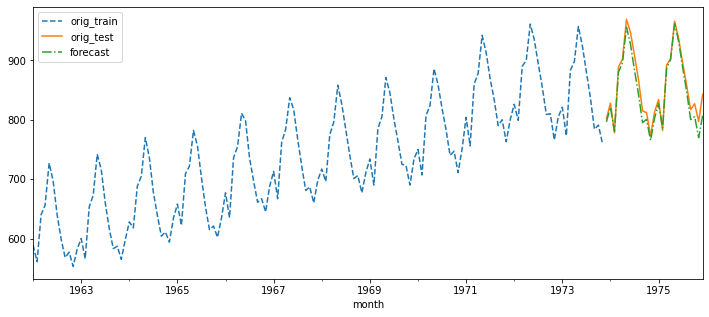

In [68]:
plot_forecast(best_model, '1962', milk_train, milk_test)

In [69]:
# We can also store the results from training the models in a tabular format

pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135856,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328241,27.797333,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998613,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289726,24.535339,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
...,...,...,...,...,...,...,...,...,...,...
211,9,"(0, 0, 1)","(0, 0, 1)",1793.898287,1794.090287,1802.477724,7.839434,676.602331,0.736908,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
212,16,"(0, 0, 2)","(0, 0, 0)",1918.255872,1918.432342,1927.080799,9.732184,839.743167,0.963643,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
213,1,"(0, 0, 0)","(0, 0, 1)",1951.580397,1951.674885,1957.315466,8.075222,694.500229,0.771746,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
214,8,"(0, 0, 1)","(0, 0, 0)",2089.817778,2089.904734,2095.715298,9.845281,848.617454,0.979283,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
